In [ ]:
!python3 -m pip install pegasuspy
!sudo apt install build-essential
!pip install gdown
!pip install torch
!pip install numpy
!pip install tqdm
!pip install matplotlib
!pip install scanpy
!pip3 install leidenalg

     |████████████████████████████████| 2.2 MB 4.2 MB/s 
     |████████████████████████████████| 208 kB 35.9 MB/s 
     |████████████████████████████████| 41 kB 107 kB/s 
     |████████████████████████████████| 8.8 MB 18.4 MB/s 
     |████████████████████████████████| 11.3 MB 46.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 127 kB 46.8 MB/s 
     |████████████████████████████████| 659 kB 41.6 MB/s 
     |████████████████████████████████| 23.2 MB 48.3 MB/s 
     |████████████████████████████████| 86 kB 5.6 MB/s 
     |████████████████████████████████| 2.1 MB 35.9 MB/s 
     |████████████████████████████████| 1.3 MB 44.5 MB/s 
     |████████████████████████████████| 61.2 MB 2.1 kB/s 
     |████████████████████████████████| 148 kB 46.6 MB/s 
     |████████████████████████████████| 146 kB 45.4 MB/s 
     |████████████████████████████████| 3.2 MB 44.8 MB/s 
     |█

In [ ]:
import pandas as pd
import os
import pickle
import torch
import numpy as np
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import scanpy as sc
import pegasus as pg
import pegasusio
torch.set_num_threads(2)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **iSEEEK FeatureExtractor**

In [ ]:
### Definition of iSEEEK FeatureExtractor
def iseeek_feature(model, model_vocab, top_ranking_gene_list = []):
  Xs = []
  for s in tqdm(top_ranking_gene_list):
    a = ['[CLS]'] + s.split()[0:126] + ['[SEP]']
    input_ids = torch.tensor([model_vocab[k] for k in a]).unsqueeze(0).cuda()
    token_type_ids = torch.zeros_like(input_ids).cuda()
    attention_mask = torch.ones_like(input_ids).cuda()
    with torch.no_grad():
      feature = model(input_ids,token_type_ids,attention_mask)
    Xs.append(feature.cpu())
  Xs = torch.cat(Xs)
  features = pd.DataFrame(Xs.numpy(), columns=['Feature{}'.format(i) for i in range(Xs.shape[1])])
  return features

# **Model** **&** **Tokenizer** **Loading** 

In [ ]:
!gdown https://drive.google.com/uc?id=1qorygy9HgJSGMgkv0QKdtDfW-K9o3wCY ### Download the File==Vocabulary of gene Tokenizer.
!gdown https://drive.google.com/uc?id=1WEc6v4mG1plPTPMaeLvl7hR1JGPHnUBn ### Download the File==Pre-trained iSEEEK Model.
model_vocab = pickle.load(open('iSEEEK_vocab.pkl',"rb")) ### Load the Vocalulary of gene Tokenizer.
genes = model_vocab.keys()
model = torch.jit.load("iSEEEK.pt") ### Load the iSEEEK model.
model = model.cuda()
model.eval()
print("###End loading model###")

Downloading...
From: https://drive.google.com/uc?id=1qorygy9HgJSGMgkv0QKdtDfW-K9o3wCY
To: /content/iSEEEK_vocab.pkl
100% 242k/242k [00:00<00:00, 34.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WEc6v4mG1plPTPMaeLvl7hR1JGPHnUBn
To: /content/iSEEEK.pt
100% 150M/150M [00:00<00:00, 158MB/s]
###End loading model###


## **Data Preparing**

In [ ]:
!gdown https://drive.google.com/uc?id=1sLEMyCDv05nBGqHqFX6QoJ54RiguUrww
!gdown https://drive.google.com/uc?id=1RoP9ygs2oETIRif9royAzaB1CGlftK5m
!gdown https://drive.google.com/uc?id=1aLMDhZ6qtGsEJpDbazXEFhvq_0trQyx5
top_ranking_genes = [i for i in open("gene_rank_HCA_immune_processed.txt")]
label = [i for i in open("labels_HCA_immune_processed.txt")]
batch = [i for i in open("batch_HCA_immune_processed.txt")]

Downloading...
From: https://drive.google.com/uc?id=1sLEMyCDv05nBGqHqFX6QoJ54RiguUrww
To: /content/batch_HCA_immune_processed.txt
3.39MB [00:00, 106MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RoP9ygs2oETIRif9royAzaB1CGlftK5m
To: /content/gene_rank_HCA_immune_processed.txt
255MB [00:02, 106MB/s]
Downloading...
From: https://drive.google.com/uc?id=1aLMDhZ6qtGsEJpDbazXEFhvq_0trQyx5
To: /content/labels_HCA_immune_processed.txt
4.19MB [00:00, 110MB/s]


# **iSEEEK Feature Extraction**

In [ ]:
iseeek_Xs = iseeek_feature(model,model_vocab,top_ranking_genes)
print(iseeek_Xs)

100%|██████████| 282558/282558 [47:07<00:00, 99.94it/s] 


        Feature0  Feature1  Feature2  ...  Feature573  Feature574  Feature575
0      -1.116546 -0.461417 -0.041155  ...    0.040574    0.143019    0.317437
1      -1.323840 -1.324151 -0.762049  ...    0.429084    1.326058    0.300451
2      -0.888102 -0.277189 -0.667489  ...    1.087736    0.766933    1.340427
3      -0.410665 -2.100882 -1.064037  ...   -0.379090    0.790672    0.043768
4      -0.746232  0.420105 -0.434697  ...    0.714307    0.612672    0.023392
...          ...       ...       ...  ...         ...         ...         ...
282553  0.022939 -1.508191  0.633147  ...    0.064210    1.441972    0.334890
282554 -0.098398  0.487079  0.288712  ...    0.427641    0.834641    0.678436
282555 -0.721754  0.270103  0.740867  ...    1.929380    0.074893    0.977276
282556  0.670738 -0.562560  1.609698  ...    0.879900    0.123680    0.752338
282557 -0.923465  0.402176  0.965289  ...   -0.044118    1.513823    0.173426

[282558 rows x 576 columns]


# **Single-cell Clustering**
* Develop KNN-graph
* Single-cell Clustering (Leiden/louvain)
* Visualization




In [ ]:
adata = sc.AnnData(iseeek_Xs)
adata.obs['celltype'] = label
adata.obs['celltype'] = adata.obs['celltype'].astype("category")
adata.obs['batch'] = batch
adata.obs['batch'] = adata.obs['batch'].astype("category")
sc.pp.neighbors(adata, use_rep="X")
sc.tl.umap(adata)
sc.tl.leiden(adata)

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


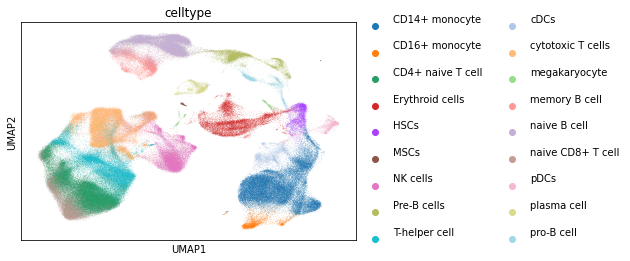

In [ ]:
##################  Cell Type  #######################
sc.pl.umap(adata, color = ["celltype"], show = True)

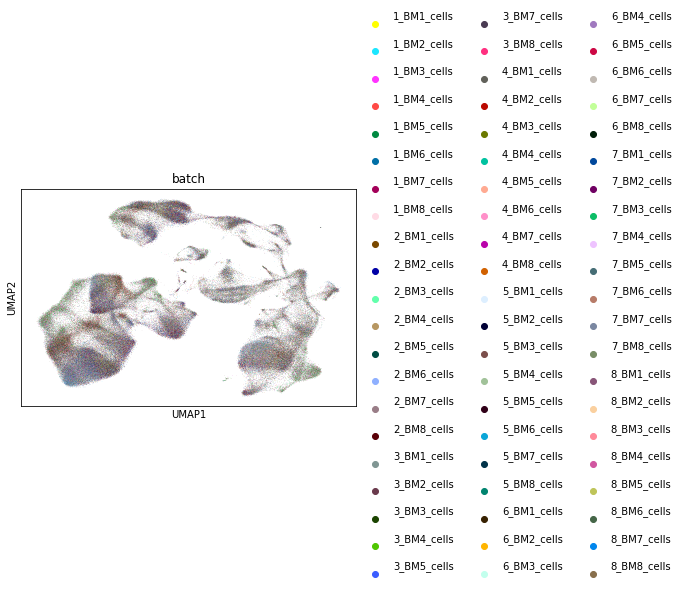

In [ ]:
#####################  Batch  #######################
sc.pl.umap(adata, color = ["batch"], show = True)

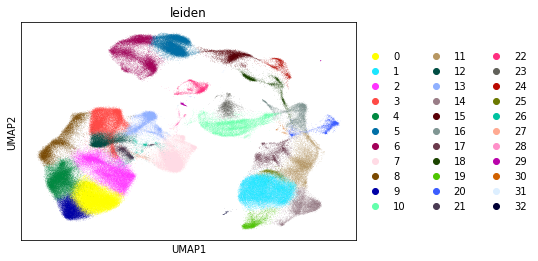

In [ ]:
############ Single-cell Clustering  #############
sc.pl.umap(adata, color = ["leiden"], show = True)

# **Diffusion-Pseudotime Analysis**



In [ ]:
adata = pegasusio.multimodal_data.MultimodalData(sc.AnnData(iseeek_Xs))
adata.obs['celltype'] = [i.strip() for i in label]
adata.obs['celltype'] = adata.obs['celltype'].astype("category")
adata.obsm["X_pca"] = np.asarray(iseeek_Xs)
pg.neighbors(adata,K =30)
pg.diffmap(adata)
pg.fle(data)

**Diffusion-Pseudotime Visualization**

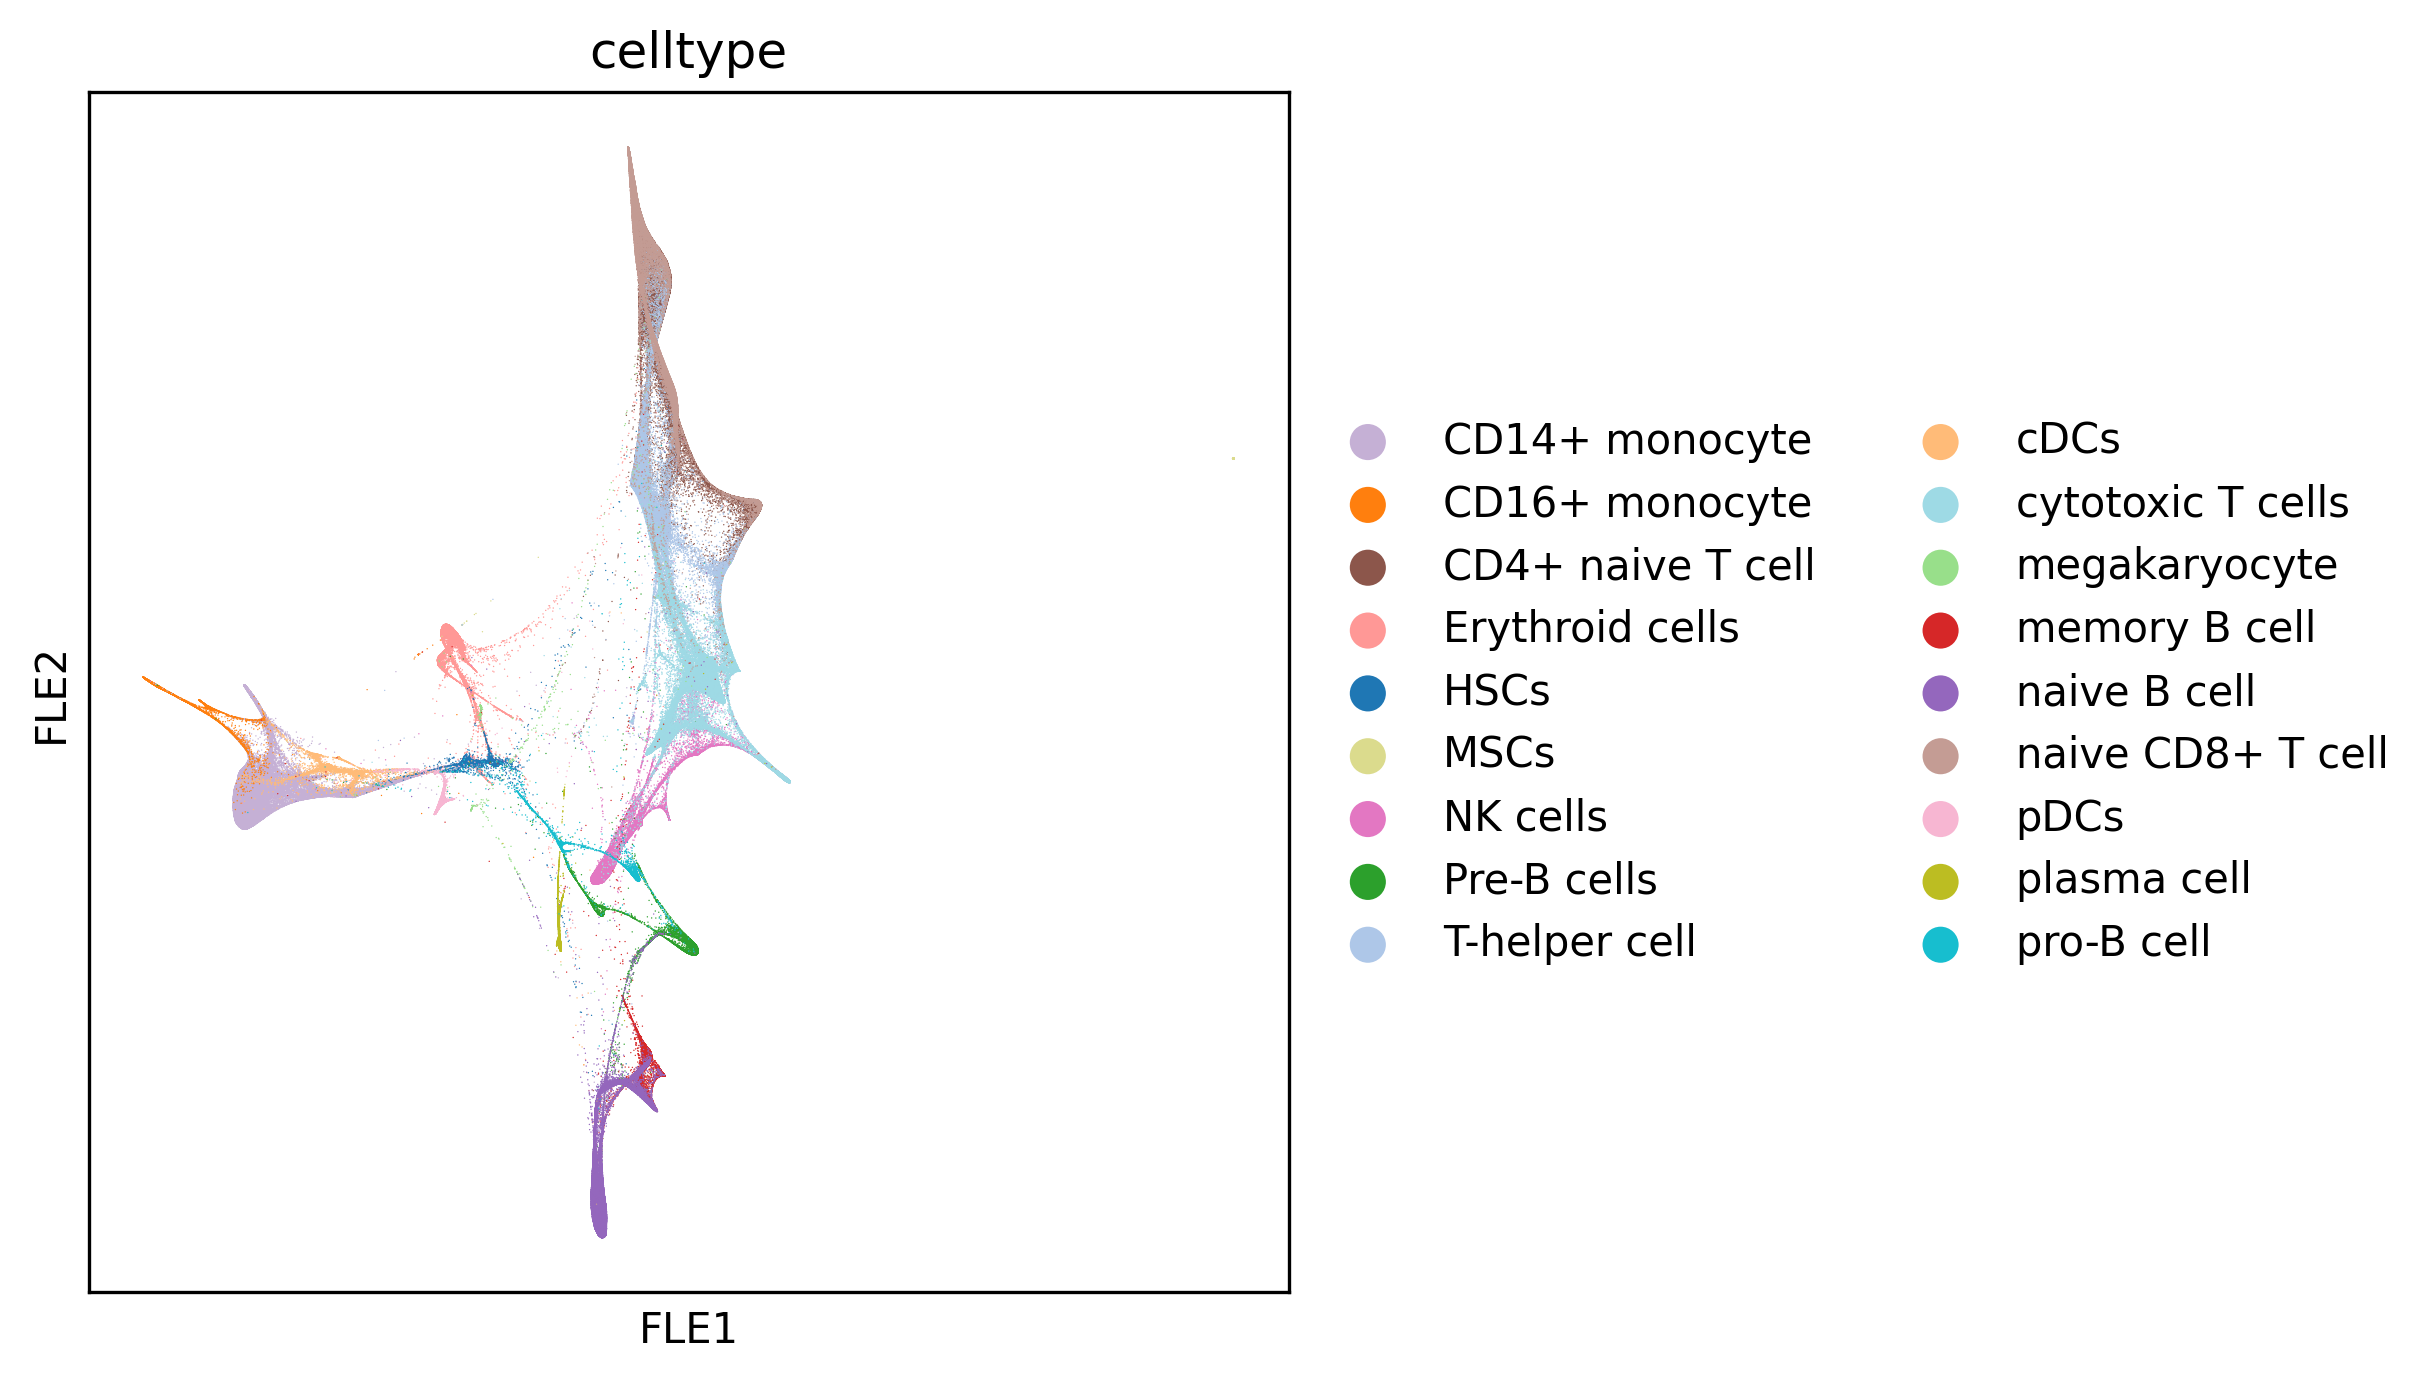

In [ ]:
pg.scatter(adata, attrs=["celltype"],show=True,basis='fle')